In [1]:
from fastai.vision import *
from glob import glob
from pathlib import *
import imghdr
from glob import glob
import os
import torch
import cv2

torch.cuda.device(0)

In [2]:
path = Path('..')
original_path = path/'is_ocr_images'
crappy_images = path/'crappy_images'

original_images_sample = path/'cycle_gan_sample/testA'
crappy_images_sample = path/'cycle_gan_sample/testB'

In [3]:
# valid_images = glob('../crappy_images/*.jpg')
# for img in valid_images:
#     if imghdr.what(img) == None:
#         print('Unlink invalid image: {}'.format(img))
#         os.remove(img)

In [4]:
# src = ImageImageList.from_folder(crappy_images).split_by_rand_pct(0.1, seed=42)

src_sample = ImageImageList.from_folder(crappy_images_sample, ignore_empty=True).split_by_rand_pct(0.01, seed=42)

In [5]:
def get_data(source, original_path_reference, bs, size):
  data = (
      source
        .label_from_func(lambda x: original_path_reference/x.name)
        .transform(size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True)
  )
  data.c = 3
  return data

In [6]:
# data_gen = get_data(src, original_path, 1, 800)
data_gen_sample = get_data(src_sample, original_images_sample, 1, 500)

In [7]:
def create_gen_learner(data):
  return unet_learner(data, arch=models.resnet34, wd=1e-3, blur=False, norm_type=NormType.Weight, self_attention=True, loss_func=MSELossFlat())

In [8]:
# learner = create_gen_learner(data_gen)
learner_sample = create_gen_learner(data_gen_sample)

In [ ]:
# learner.summary()

In [9]:
learner_sample.fit_one_cycle(50, pct_start=0.7)

epoch,train_loss,valid_loss,time
0,0.221054,0.212643,05:39
1,0.145193,0.204369,05:41
2,0.169503,0.219165,05:39
3,0.188184,0.225915,05:49
4,0.179761,0.222512,05:47
5,0.190819,0.190764,05:57
6,0.213389,0.192428,06:03
7,0.181298,0.218477,05:57
8,0.159344,0.202661,05:54
9,0.146464,0.189581,05:50


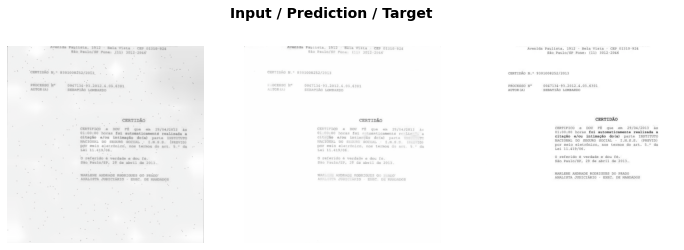

In [11]:
learner_sample.show_results(rows=10)

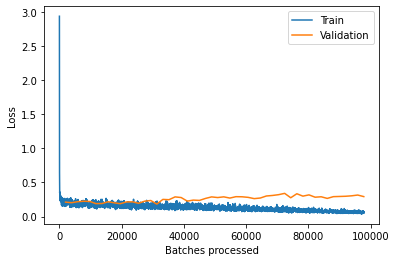

In [14]:
learner_sample.recorder.plot_losses()

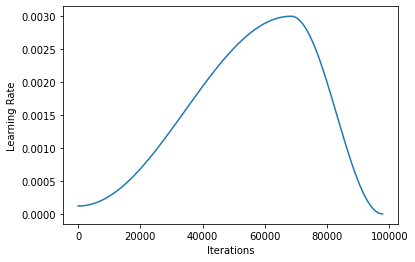

In [16]:
learner_sample.recorder.plot_lr()

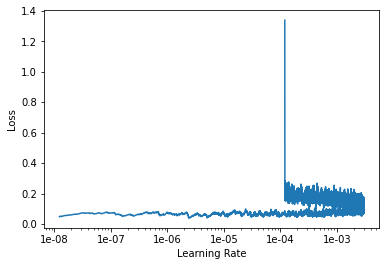

In [13]:
learner_sample.recorder.plot()

In [ ]:
# learner.save('original_model_decrap_v2_768')
learner.save('original_model_decrap_v2_800')

In [ ]:
# learner.export('original_model_decrap_v2_768')
learner.export('original_model_decrap_v2_800')

In [ ]:
#learner.load('original_model_decrap_v2_768')
learner = learner.load('original_model_decrap_v2_800')
learner.fit_one_cycle(1)
learner.recorder.plot_losses()

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(2, slice(1e-3, 1e-6))

In [ ]:
learner.show_results(rows=10)

In [ ]:
learner = learner.load('original_model_decrap_v2')

In [ ]:
learner.save('original_model_decrap_retrained')

In [ ]:
crap_test = glob('./testB/*.jpg')

In [ ]:
# print(data_gen.train_ds)
# learner.predict(data_gen.train_ds[20][0])[0].save('./predicted_988167_310103076_19.jpg')
import timeit
preprocess_time = []
for index, p in enumerate(learner_sample.data.train_ds[:1000]):
#     p[0].save('./predicted_decrapp_v2_800/crappy/{}.jpg'.format(index))
#     p[1].save('./predicted_decrapp_v2_800/original/{}.jpg'.format(index))
    tic = timeit.default_timer()
    learner.predict(p[0])
    toc = timeit.default_timer()
    preprocess_time.append(toc - tic)
# learner_sample.data.train_ds[0][1].save('cu.png')
# learner.data.train_ds.items[20]
# learner.predict(learner.data.train_ds[21][0])[0]
# learner_sample.data.train_ds[0][0]
# learner.predict(learner_sample.data.train_ds[0][0])[0]
from statistics import mean, median
mean(preprocess_time)

In [ ]:
imgl = ImageImageList.from_folder('../test_images/').split_none()
dimgl = (
  imgl
    .label_from_func(lambda x: '../test_images/{}'.format(x.name))
    .databunch(bs=1)
    .normalize(imagenet_stats, do_y=True)
)
dimgl.c = 3

In [ ]:
print(dimgl.train_ds)
learner.predict(dimgl.train_ds[0][0])[0]

In [ ]:
import rouge
import csv
import os
import re
import shutil
import collections
from datetime import datetime

class RougeMetric:
    """
    Rouge Metric class to compute both Rouge-N and Rouge-L summarization metrics;

    Parameters
    ----------
    - max_n: int, optional, default to 4
        Defines maximum N value to Rouge-N metric
    - alpha: float, optional, default to 0.5
        # TODO: describe alpha argument
    - weight_factor: float, optional, default to 1.2
        # TODO: describe weight_factor argument
    - batch_size: int, optional, default to 1000
        Defines the size of the batches that the data will be divided by.

    Attributes
    ----------
    - data: array
        Stores the loaded data value containing file reference, original text reference, simple image processing reference, GAN processing reference and Decrappification reference
    - computed_data_size: int
        Stores the count of processed data
    - rouge_instance: Rouge
        Instance of Rouge metric
    - BATCH_SIZE: int, imutable
        Stores the batch size
    """
    data = []
    computed_data_size = 0
    max_n = 1
    rouge_instance = {}
    BATCH_SIZE = 1000

    def __init__(self, max_n=4, alpha=0.5, weight_factor=1.2, batch_size=1000):
        self.rouge_instance = rouge.Rouge(
                metrics=['rouge-n', 'rouge-l'],
                max_n=max_n,
                limit_length=True,
                length_limit=100,
                length_limit_type='words',
                apply_avg=True,
                alpha=alpha,
                weight_factor=weight_factor,
                stemming=True
            )

        self.BATCH_SIZE = batch_size


    def compute_metric_value(self):
        """
        Get stored data and apply both Rouge-N and Rouge-L metrics to it.
        It consider both computed_data_size and data class arguments to compute only remaining data.

        It changes the class data attribute to an array object keys to contain:
        - text: current data reference text or original text
        - rouge_metric: contains the result of Rouge metrics
        """
 
        start = 0
        end = len(self.data)
        if self.computed_data_size % self.BATCH_SIZE == 0:
            start = self.computed_data_size
        slice_obj = slice(start, end)
        for data in self.data[slice_obj]:
            # print('Evaluating data for "{}" file'.format(data['file_reference']))
            data_reference = data['reference']
            for key in ['simple_processor', 'gan_processor', 'decrappification_processor', 'crappy_processor']:
                data[key] = {
                        'text': data[key],
                        'rouge_metric': self.rouge_instance.get_scores(data[key], data_reference)
                    }
            self.computed_data_size += 1


    def store_data(self, file_reference, reference, simple_processor, gan_processor, decrappification_processor, crappy_reference=None):
        """
        Store loaded data as an object containing.

        Parameters
        ----------
        - file_reference: str
            Path to original file
        - reference: str
            Original text of the file_reference
        - simple_processor: str
            Text containing the OCR result of images generated by simple image processor
        - gan_processor: str
            Text containing the OCR result of images generated by GAN model image processor
        - decrappification_processor: str
            Text containing the OCR result of images generated by Decrappification image processor
        - crappy_reference: str, optional
            Text containing the OCR result from crappy image
        """

        data_length = len(self.data)
        if data_length % self.BATCH_SIZE == 0 and data_length > 0:
            self.compute_metric_value()

        ref_dict = {
                'file_reference': file_reference,
                'reference': reference,
                'simple_processor': simple_processor,
                'gan_processor': gan_processor,
                'decrappification_processor': decrappification_processor,
                'crappy_processor': crappy_reference if crappy_reference is not None else ''
            }
        self.data.append(ref_dict)


    def export_data(self, filename, delimiter=';'):
        """
        Export stored data to CSV file. If given filename exists, it will create a backup file.

        Parameters
        ----------
        - filename: str
            Path to destination file
        - delimiter: str, default to ';'
            CSV delimiter

        Returns
        -------
        - result: dict
            The result dict contains 'rows' (int) and 'backup_filename' (str) keys.
            'rows' define the count of written data on file and 'backup_filename' is the backup filename if
            the given filename exists.
        """
        if self.computed_data_size != len(self.data):
            self.compute_metric_value()

        if os.path.exists(filename):
            timestamp_now = datetime.now().timestamp()
            name = filename
            if re.search('\.csv$', filename):
                name = name.replace('.csv', '')

            backup_filename = '{}-{}.csv'.format(name, timestamp_now)
            print('Warn: {} exists. Moving it to {}'.format(filename, backup_filename))
            shutil.move(filename, backup_filename)

        with open(filename, 'w') as csvfile:
            writer = None
            header = ['file_reference']
            header_written = False
            # TODO: minimize method complexity
            for i, data in enumerate(self.data):
                row = {
                        'file_reference': data['file_reference']
                    }
                for index, key in enumerate(data):
                    if re.search('processor', key):
                        processor = key.split('_')[0]
                        metric_value = list(sorted(data[key]['rouge_metric'].items(), key=lambda x: x[0]))
                        for metric_key, value in metric_value:
                            row_key = '{}_{}'.format(processor, metric_key)
                            if i == 0:
                                header.append(row_key)
                            row[row_key] = value
                if i == 0:
                    writer = csv.DictWriter(csvfile, fieldnames=header, delimiter=delimiter)
                    writer.writeheader()
                writer.writerow(row)

In [ ]:
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
metric = RougeMetric()


for index in range(1000):
    if index % 100 == 0:
        print('batch: {}'.format(index))
    # get image paths
    original = './predicted_decrapp_v2_800/original/{}.jpg'.format(index)
    crappy = './predicted_decrapp_v2_800/crappy/{}.jpg'.format(index)
    predicted = './predicted_decrapp_v2_800/predicted/{}.jpg'.format(index)
    
    # correct image


    # extract text from images
    original_image = cv2.imread(original)
    original_text = pytesseract.image_to_string(original, lang='por+eng')
    
    crappy_image = cv2.imread(crappy)
    crappy_text = pytesseract.image_to_string(crappy_image, lang='por+eng')
    
    predicted = cv2.imread(predicted)
    corrected_text = pytesseract.image_to_string(predicted, lang='por+eng')
    
    metric.store_data(p, original_text, corrected_text, '', '', crappy_text)

In [ ]:
metric.export_data('decrappy_metric_data.csv')

In [ ]:
import csv

c_rouge_1 = []
c_rouge_2 = []
c_rouge_3 = []
c_rouge_4 = []
c_rouge_l = []

s_rouge_1 = []
s_rouge_2 = []
s_rouge_3 = []
s_rouge_4 = []
s_rouge_l = []


indexes = [1, 2, 3, 4, 5, 16, 17, 18, 19, 20]
w,h = 10, 10
rouges = [[0 for x in range(w)] for y in range(h)] 
with open('decrappy_metric_data.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    index = 0
    for line in reader:
        if index == 0:
            index += 1
            continue
        for i, m_index in enumerate(indexes):
            if eval(line[m_index])['f'] > 0:
                rouges[i].append(eval(line[m_index])['f'])
            else:
                continue
#         print(eval(line[1])['f'])
        if index == 10:
            break
            
def gt_0 (v):
    print(v)
    return v > .0

list(map(lambda x: mean(x), rouges))